In [1]:
%matplotlib inline

In [2]:
# import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

In [3]:
gps = pd.read_csv("/var/Train_Test_IoT_GPS_Tracker.csv")

In [4]:
gps.head()

,ts,date,time,latitude,longitude,label,type
0,1556242299,25-Apr-19,18:31:39,116.521704,132.162504,1,ddos
1,1556242301,25-Apr-19,18:31:41,121.742933,135.072500,1,ddos
2,1556242306,25-Apr-19,18:31:46,121.795929,135.110198,1,ddos
3,1556242309,25-Apr-19,18:31:49,116.611216,132.224555,1,ddos
4,1556242311,25-Apr-19,18:31:51,121.841526,135.151362,1,ddos


In [5]:
gps.drop(columns=['ts','date', 'time', 'label'],inplace=True)

In [6]:
gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58960 entries, 0 to 58959
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   58960 non-null  float64
 1   longitude  58960 non-null  float64
 2   type       58960 non-null  object 
dtypes: float64(2), object(1)
memory usage: 1.3+ MB


In [7]:
gps['type'].value_counts()

normal        35000
injection      5000
password       5000
backdoor       5000
ddos           5000
ransomware     2833
xss             577
scanning        550
Name: type, dtype: int64

In [8]:
label_type = LabelEncoder()
gps['type']=label_type.fit_transform(gps['type'])

In [9]:
gps['type'].value_counts()

3    35000
4     5000
2     5000
1     5000
0     5000
5     2833
7      577
6      550
Name: type, dtype: int64

In [10]:
gps.isnull().sum()

latitude     0
longitude    0
type         0
dtype: int64

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(gps, gps['type']):
  strat_train = gps.loc[train_index]
  strat_test = gps.loc[test_index]

In [12]:
gps = strat_train.copy()

In [13]:
gps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41272 entries, 16485 to 655
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   41272 non-null  float64
 1   longitude  41272 non-null  float64
 2   type       41272 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.3 MB


In [14]:
##pipeline creation

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
my_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

In [15]:
X_train=gps.drop("type", axis = 1)
Y_train=gps['type'].copy()
X_test = strat_test.drop("type",axis = 1)
Y_test = strat_test['type'].copy()

In [16]:
X_train = my_pipe.fit_transform(X_train)
X_test = my_pipe.fit_transform(X_test)

# add rus here

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
#import for normalize, cross val, kfold, randomsearch
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

##n_estimators is number of weak learners to train iteratively
##learning_rate is weight of weak learners
abcgps = AdaBoostClassifier(n_estimators = 50, random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
n_scores=cross_val_score(abcgps, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
print('Accuracy: %3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.636121 (0.010)


In [18]:
abcgps.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [19]:
y_pred = abcgps.predict(X_test)

In [20]:
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.27      0.80      0.41      1500
           1       0.45      0.50      0.47      1500
           2       0.00      0.00      0.00      1500
           3       0.96      0.81      0.88     10500
           4       0.00      0.00      0.00      1500
           5       0.27      0.90      0.42       850
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00       173

    accuracy                           0.63     17688
   macro avg       0.24      0.38      0.27     17688
weighted avg       0.65      0.63      0.62     17688



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


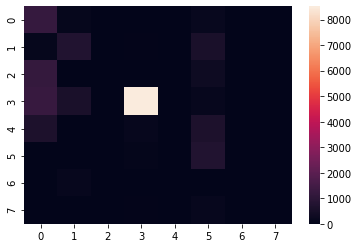

In [21]:
cm = metrics.confusion_matrix(Y_test, y_pred)
import seaborn as sns
sns.heatmap(cm)

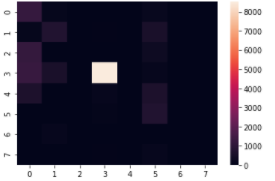

## **Hyper Parameter Tuning**

In [22]:
parameters = {"learning_rate":[0.1,0.01,0.001],
              "n_estimators":[100,250,500,1000]}
search = RandomizedSearchCV(abcgps, param_distributions=parameters, scoring='accuracy', cv=10,
                            verbose=3, random_state=42)

In [23]:
model_abc = search.fit(X_train, Y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  18.9s
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  18.7s
[CV] n_estimators=500, learning_rate=0.001 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.6s remaining:    0.0s


[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  19.0s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  20.0s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  19.1s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  19.9s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  21.6s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  20.4s
[CV] n_estimators=500, learning_rate=0.001 ...........................
[CV]  n_estimators=500, learning_rate=0.001, score=0.594, total=  19.2s
[CV] n_estimators=500, learning_rate=0.001 ...........................

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 26.3min finished


In [24]:
abc_final = AdaBoostClassifier(random_state=42, n_estimators=model_abc.best_params_['n_estimators'],learning_rate=model_abc.best_params_['learning_rate'])
abc_final.fit(X_train, Y_train)

y_pred1 = abc_final.predict(X_test)

In [25]:
print(metrics.classification_report(Y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1500
           1       0.00      0.00      0.00      1500
           2       0.34      0.40      0.37      1500
           3       0.74      0.98      0.85     10500
           4       0.25      0.34      0.29      1500
           5       0.00      0.00      0.00       850
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00       173

    accuracy                           0.65     17688
   macro avg       0.17      0.22      0.19     17688
weighted avg       0.49      0.65      0.56     17688



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


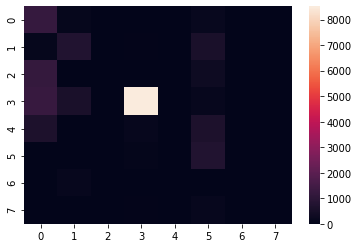

In [26]:
cm1 = metrics.confusion_matrix(Y_test, y_pred1)
import seaborn as sns
sns.heatmap(cm)